In [2]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import pubchempy as pcp
import time
pd.options.display.max_columns = None
import uniprot as up
import pprint
import csv
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
#First I need to remove rows from the IUPHAR ligand mapping that do not have PubChem CID
df_mapping = pd.read_csv('ligand_id_mapping (1).csv')
print(df_mapping.shape)
df_mapping.dropna(subset = ['PubChem CID'], inplace = True)
df_mapping.to_csv('IUPHAR-ligand_mapping.csv')
print(df_mapping.shape)

(10823, 14)
(8307, 14)


In [113]:
#Now using the PubChem CID I need to get the molecular properties available from pubchem using the pubchempy package, which gets mad if you ask too much of it
df2 = pd.read_csv('PubChem_substance_id_list_summary.csv')
df2.dropna(subset = ['cid'], inplace = True)
cid_list = df2.cid.to_list()
cid_list = [int(cid_list) for cid_list in cid_list]

comp_dict_list1 = []
for i in range(len(cid_list)):
    if i % 100 == 0:
        time.sleep(60)
        print(i) 
    comp_dict = pcp.get_properties(list_props, cid_list[i])
    comp_dict_list1.append(comp_dict)
# comp_dict_list


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200


In [143]:
# Save all the information to a csv
comp_dict_list2 = pd.DataFrame(comp_dict_list1)
comp_dict_list2 = comp_dict_list2[0].apply(pd.Series)
comp_dict_list2.to_csv('pubchem-molecular_info.csv')

In [3]:
df_pubchem = pd.read_csv('pubchem-molecular_info.csv')
df_pubchem.CID = df_pubchem.CID.astype(str)
df_pubchem.dtypes

Unnamed: 0                    int64
CID                          object
MolecularFormula             object
MolecularWeight             float64
CanonicalSMILES              object
IsomericSMILES               object
InChI                        object
InChIKey                     object
IUPACName                    object
XLogP                       float64
ExactMass                   float64
MonoisotopicMass            float64
TPSA                        float64
Complexity                    int64
Charge                        int64
HBondDonorCount               int64
HBondAcceptorCount            int64
RotatableBondCount            int64
HeavyAtomCount                int64
IsotopeAtomCount              int64
AtomStereoCount               int64
DefinedAtomStereoCount        int64
UndefinedAtomStereoCount      int64
BondStereoCount               int64
DefinedBondStereoCount        int64
UndefinedBondStereoCount      int64
dtype: object

In [6]:
# Merge mapping and pubchem info dataframes
df_pubchem_mapping = pd.merge(df_pubchem, df_mapping[['Ligand id', 'Type', 'PubChem CID']], left_on = 'CID', right_on = 'PubChem CID')

In [7]:
# Read in data frame with the ligand and target information
df_iuphar = pd.read_csv('IUPHAR-interactions.csv')
df_iuphar.dropna(subset = ['target'], inplace = True)
df_iuphar

#Merge the target information dataframe with the mapping and pubchem dataframes
df_pubchem_mapping_iuphar = pd.merge(df_pubchem_mapping, df_iuphar[['ligand_id', 'ligand', 'type', 'action', 'target_species', 'selectivity', 'endogenous', 'target', 'primary_target', 
                                                                   'target_uniprot']], left_on = 'Ligand id', right_on = 'ligand_id')
df_pubchem_mapping_iuphar.dropna(subset = ['target_uniprot'], inplace = True)
df_pubchem_mapping_iuphar.target_uniprot = df_pubchem_mapping_iuphar.target_uniprot.str.split('|').str[0]
df_pubchem_mapping_iuphar

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,7,8,9,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Unnamed: 0        CID MolecularFormula  MolecularWeight  \
0               0    5280892         C20H32O4           336.50   
1               1      62907         C13H25NO           211.34   
2               2      65300         C10H21NO           171.28   
3               3   21037647      C20H25ClN4S           389.00   
4               3   21037647      C20H25ClN4S           389.00   
...           ...        ...              ...              ...   
16457        7227  154699468        C23H33NO7           435.50   
16460        7230  146421275       C30H37N7O2           527.70   
16461        7230  146421275       C30H37N7O2           527.70   
16462        7230  146421275       C30H37N7O2           527.70   
16463        7230  146421275       C30H37N7O2           527.70   

                                         CanonicalSMILES  \
0                      CCCCCC=CCC(C=CC=CCC=CCCCC(=O)O)OO   
1                               CCNC(=O)C1CC(CCC1C(C)C)C   
2                                CC(C)C(C)(C(C)C)C(=O)NC   
3      CC(C)(C)C1=CC=C(C=C1)NC(=S)N2CCN(CC2)C3=C(C=CC...   
4      CC(C)(C)C1=CC=C(C=C1)NC(=S)N2CCN(CC2)C3=C(C=CC...   
...                                                  ...   
16457  C1=CC2=C(C=CC(=C2)OCCCCCCCCOC3C(C(OC(C3O)O)CO)...   
16460  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   
16461  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   
16462  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   
16463  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   

                                          IsomericSMILES  \
0          CCCCC/C=C\C[C@@H](/C=C/C=C\C/C=C\CCCC(=O)O)OO   
1                               CCNC(=O)C1CC(CCC1C(C)C)C   
2                                CC(C)C(C)(C(C)C)C(=O)NC   
3      CC(C)(C)C1=CC=C(C=C1)NC(=S)N2CCN(CC2)C3=C(C=CC...   
4      CC(C)(C)C1=CC=C(C=C1)NC(=S)N2CCN(CC2)C3=C(C=CC...   
...                                                  ...   
16457  C1=CC2=C(C=CC(=C2)OCCCCCCCCO[C@H]3[C@@H]([C@H]...   
16460  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   
16461  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   
16462  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   
16463  CCC1=C(C=CC(=C1)O)C2=CC3=C(C=C2)C(=NN3)C4=NC5=...   

                                                   InChI  \
0      InChI=1S/C20H32O4/c1-2-3-4-5-10-13-16-19(24-23...   
1      InChI=1S/C13H25NO/c1-5-14-13(15)12-8-10(4)6-7-...   
2      InChI=1S/C10H21NO/c1-7(2)10(5,8(3)4)9(12)11-6/...   
3      InChI=1S/C20H25ClN4S/c1-20(2,3)15-6-8-16(9-7-1...   
4      InChI=1S/C20H25ClN4S/c1-20(2,3)15-6-8-16(9-7-1...   
...                                                  ...   
16457  InChI=1S/C23H33NO7/c25-15-19-20(26)22(21(27)23...   
16460  InChI=1S/C30H37N7O2/c1-6-18-11-21(38)8-10-22(1...   
16461  InChI=1S/C30H37N7O2/c1-6-18-11-21(38)8-10-22(1...   
16462  InChI=1S/C30H37N7O2/c1-6-18-11-21(38)8-10-22(1...   
16463  InChI=1S/C30H37N7O2/c1-6-18-11-21(38)8-10-22(1...   

                          InChIKey  \
0      ZIOZYRSDNLNNNJ-LQWMCKPYSA-N   
1      VUNOFAIHSALQQH-UHFFFAOYSA-N   
2      RWAXQWRDVUOOGG-UHFFFAOYSA-N   
3      ODPJGEXSZMHIBU-UHFFFAOYSA-N   
4      ODPJGEXSZMHIBU-UHFFFAOYSA-N   
...                            ...   
16457  PHDIJLFSKNMCMI-ITGJKDDRSA-N   
16460  VQIIUJSNIKEMCK-MHZLTWQESA-N   
16461  VQIIUJSNIKEMCK-MHZLTWQESA-N   
16462  VQIIUJSNIKEMCK-MHZLTWQESA-N   
16463  VQIIUJSNIKEMCK-MHZLTWQESA-N   

                                               IUPACName  XLogP   ExactMass  \
0      (5Z,8Z,10E,12S,14Z)-12-hydroperoxyicosa-5,8,10...    5.2  336.230059   
1      N-ethyl-5-methyl-2-propan-2-ylcyclohexane-1-ca...    3.5  211.193614   
2                N,2,3-trimethyl-2-propan-2-ylbutanamide    2.5  171.162314   
3      N-(4-tert-butylphenyl)-4-(3-chloropyridin-2-yl...    4.9  388.148846   
4      N-(4-tert-butylphenyl)-4-(3-chloropyridin-2-yl...    4.9  388.148846   
...                                                  ...    ...         ...   
16457  (3R,4S,5R,6R)-6-(hydroxymethyl)-4-

In [221]:
# Output list of targets to query from uniprot - they insist on using a GUI 
df_pubchem_mapping_iuphar.target_uniprot.to_csv('uniprot_list.csv', index=False)
# df_pubchem_mapping_iuphar.target_uniprot.nunique()

1971

In [17]:
# df_pubchem_mapping_iuphar.ligand_id.nunique()
df_uniprot

Entry   Entry name                                      Protein names  \
0     O35433    TRPV1_RAT  Transient receptor potential cation channel su...   
1     Q8R4D5  TRPM8_MOUSE  Transient receptor potential cation channel su...   
2     Q8R455    TRPM8_RAT  Transient receptor potential cation channel su...   
3     P10276   RARA_HUMAN  Retinoic acid receptor alpha (RAR-alpha) (Nucl...   
4     P10826   RARB_HUMAN  Retinoic acid receptor beta (RAR-beta) (HBV-ac...   
...      ...          ...                                                ...   
1966  Q9JHI9  S40A1_MOUSE  Solute carrier family 40 member 1 (Ferroportin...   
1967  Q7TMA4  FFAR4_MOUSE  Free fatty acid receptor 4 (G-protein coupled ...   
1968  Q86YT5  S13A5_HUMAN  Solute carrier family 13 member 5 (Na(+)/citra...   
1969  Q99814  EPAS1_HUMAN  Endothelial PAS domain-containing protein 1 (E...   
1970  P07766   CD3E_HUMAN  T-cell surface glycoprotein CD3 epsilon chain ...   

                                       Protein families  GPCR  
0     Transient receptor (TC 1.A.4) family, TrpV sub...     0  
1     Transient receptor (TC 1.A.4) family, LTrpC su...     0  
2     Transient receptor (TC 1.A.4) family, LTrpC su...     0  
3        Nuclear hormone receptor family, NR1 subfamily     0  
4        Nuclear hormone receptor family, NR1 subfamily     0  
...                                                 ...   ...  
1966  Ferroportin (FP) (TC 2.A.100) family, SLC40A s...     0  
1967                G-protein coupled receptor 1 family     1  
1968  SLC13A/DASS transporter (TC 2.A.47) family, NA...     0  
1969                                                NaN     0  
1970                                                NaN     0  

[1971 rows x 5 columns]

In [10]:
# This excel sheet was the output of the 
df_uniprot = pd.read_excel('uniprot-yourlist%3AM20210604F248CABF64506F29A91F8037F07B67D103E144V.xlsx')
df_uniprot['GPCR'] = df_uniprot['Protein families'].str.contains('G-protein coupled receptor', na=False).astype(int)
# df_uniprot

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


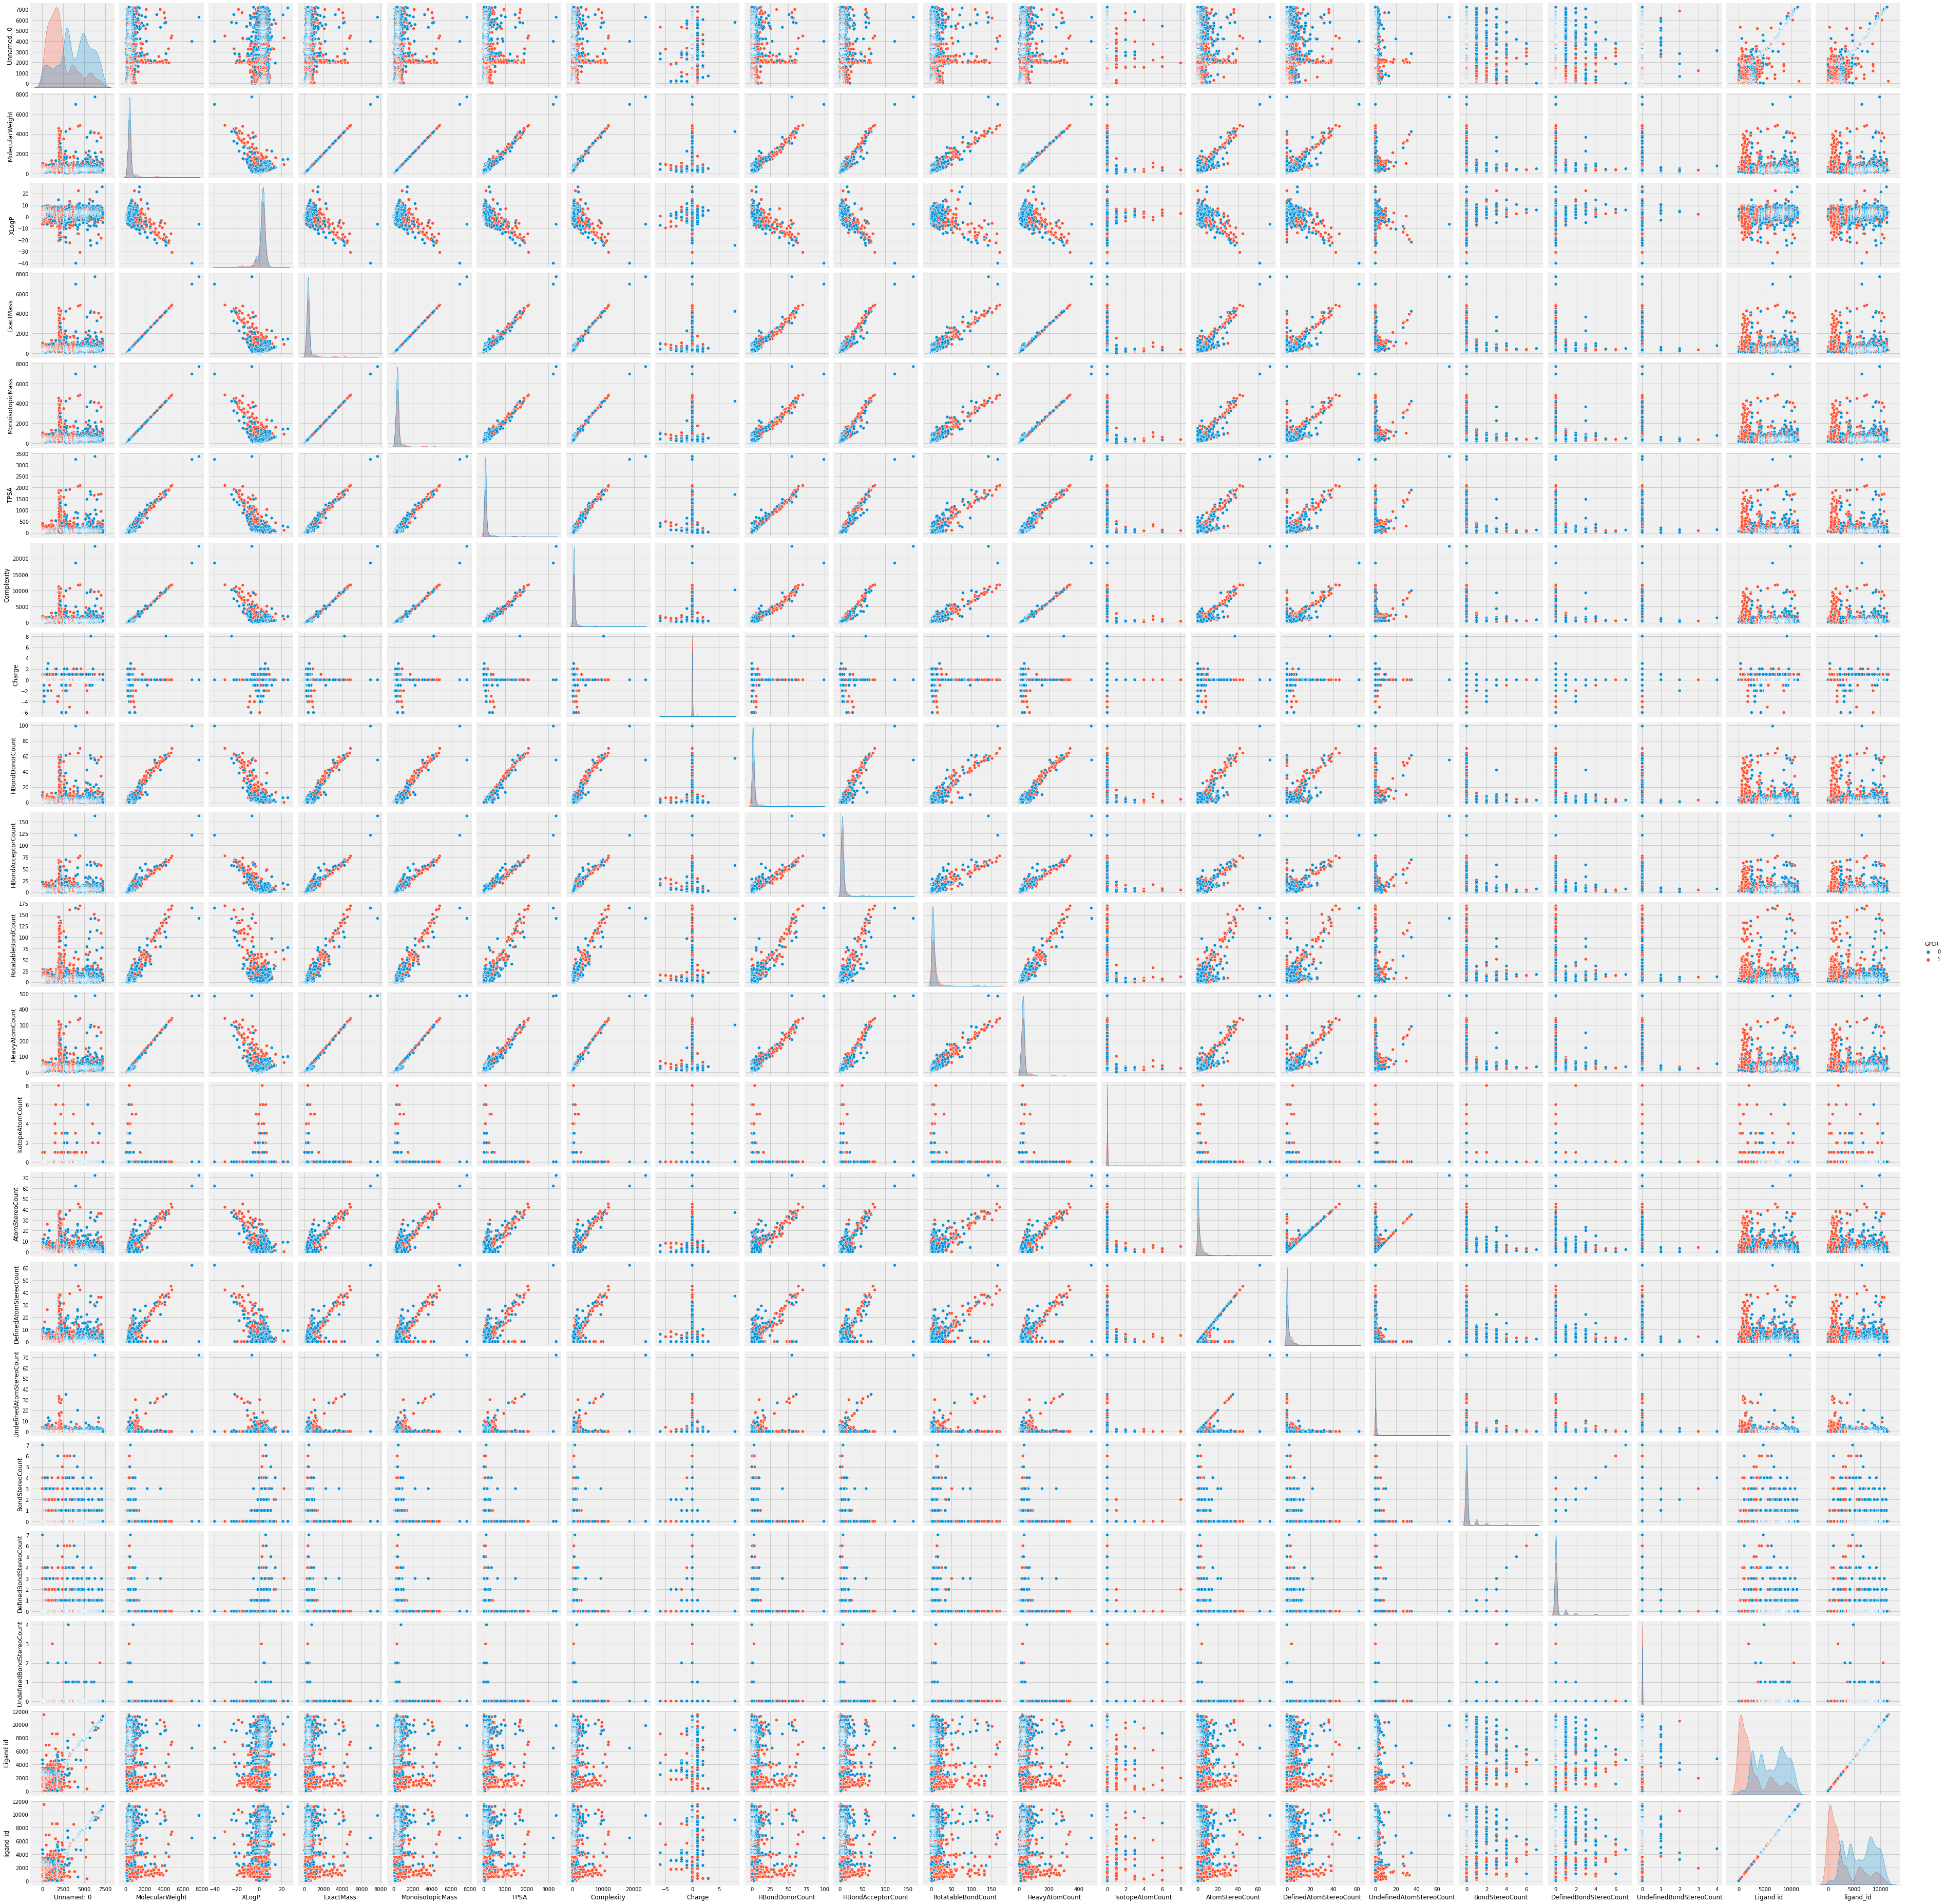

In [11]:
df_pubchem_mapping_iuphar_uniprot = pd.merge(df_pubchem_mapping_iuphar, df_uniprot[['Entry', 'GPCR']], left_on = 'target_uniprot', right_on = 'Entry')
sns.pairplot(df_pubchem_mapping_iuphar_uniprot, hue = 'GPCR')

In [13]:
df_pubchem_mapping_iuphar_uniprot.GPCR.sum()
df_pubchem_mapping_iuphar_uniprot.drop(['ligand_id', 'Ligand id', 'Unnamed: 0'], axis = 1, inplace = True)
df_pubchem_mapping_iuphar_uniprot.to_csv('df_classification.csv')
df_pubchem_mapping_iuphar_uniprot.columns

KeyError: "['ligand_id' 'Ligand id' 'Unnamed: 0'] not found in axis"

In [322]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

# calculate single molecule
mol = Chem.MolFromSmiles('c1ccccc1')
calc(mol)[:3]


# calculate multiple molecule
mols = [Chem.MolFromSmiles(smi) for smi in ['c1ccccc1Cl', 'c1ccccc1O', 'c1ccccc1N']]

# as pandas
df = calc.pandas(mols)
df['SLogP']
df

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


ABC     ABCGG  nAcid  nBase   SpAbs_A   SpMax_A  SpDiam_A    SpAD_A  \
0  5.059137  4.785854      0      0  8.720566  2.101003  4.202006  8.720566   
1  5.059137  4.785854      0      0  8.720566  2.101003  4.202006  8.720566   
2  5.059137  4.785854      0      0  8.720566  2.101003  4.202006  8.720566   

    SpMAD_A   LogEE_A     VE1_A     VE2_A    VE3_A      VR1_A    VR2_A  \
0  1.245795  2.844305  2.594165  0.370595  0.59659  18.411612  2.63023   
1  1.245795  2.844305  2.594165  0.370595  0.59659  18.411612  2.63023   
2  1.245795  2.844305  2.594165  0.370595  0.59659  18.411612  2.63023   

      VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  \
0  2.556307          6          6     12           7       0            0   
1  2.556307          6          6     13           7       0            0   
2  2.556307          6          6     14           7       0            0   

   nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX     ATS0dv  \
0        1   5   0   6   0   0   0   0   0    1    0   0   1  61.604938   
1        1   6   0   6   0   1   0   0   0    0    0   0   0  86.000000   
2        1   7   0   6   1   0   0   0   0    0    0   0   0  70.000000   

      ATS1dv     ATS2dv     ATS3dv     ATS4dv  ATS5dv  ATS6dv  ATS7dv  ATS8dv  \
0  63.111111  64.666667  34.666667   2.333333     0.0     0.0     0.0     0.0   
1  80.000000  90.000000  60.000000  15.000000     0.0     0.0     0.0     0.0   
2  72.000000  78.000000  48.000000   9.000000     0.0     0.0     0.0     0.0   

   ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  ATS6d  ATS7d  ATS8d      ATS0s  \
0   35.0   41.0   54.0   46.0   19.0    3.0    0.0    0.0    0.0  29.588630   
1   36.0   42.0   57.0   50.0   25.0    7.0    1.0    0.0    0.0  64.777778   
2   37.0   43.0   61.0   54.0   31.0   11.0    2.0    0.0    0.0  45.777778   

       ATS1s      ATS2s      ATS3s      ATS4s      ATS5s  ATS6s  ATS7s  ATS8s  \
0  34.909465  47.382716  42.740741  19.049383   3.345679    0.0    0.0    0.0   
1  48.666667  67.666667  74.666667  43.666667  12.000000    1.0    0.0    0.0   
2  47.333333  62.333333  66.666667  41.666667  14.000000    2.0    0.0    0.0   

   ATS0Z  ATS1Z  ATS2Z  ATS3Z  ATS4Z  ATS5Z  ATS6Z  ATS7Z  ATS8Z        ATS0m  \
0  510.0  348.0  480.0  410.0  170.0   19.0    0.0    0.0    0.0  2127.367546   
1  286.0  302.0  378.0  296.0  112.0   18.0    1.0    0.0    0.0  1127.649111   
2  272.0  302.0  373.0  294.0  118.0   25.0    2.0    0.0    0.0  1068.893223   

         ATS1m        ATS2m        ATS3m       ATS4m      ATS5m     ATS6m  \
0  1351.910116  1838.235506  1480.974599  561.856846  37.765728  0.000000   
1  1134.411147  1383.090672   998.723637  315.263973  32.298336  1.016064   
2  1122.596355  1348.362000   971.070117  313.568493  44.429616  2.032128   

   ATS7m  ATS8m        ATS0v        ATS1v        ATS2v        ATS3v  \
0    0.0    0.0  3200.491091  3576.780400  4612.459390  3716.565891   
1    0.0    0.0  2943.994654  3499.527625  4408.663195  3541.211345   
2    0.0    0.0  3002.001795  3609.727223  4591.045314  3817.151424   

         ATS4v       ATS5v      ATS6v  ATS7v  ATS8v      ATS0se      ATS1se  \
0  1410.336196  187.328603   0.000000    0.0    0.0   90.911041   90.373606   
1  1456.415545  321.085225  31.083744    0.0    0.0   98.905596  100.336308   
2  1776.242234  502.941874  62.167489    0.0    0.0  102.473980  106.159676   

       ATS2se      ATS3se      ATS4se     ATS5se     ATS6se  ATS7se  ATS8se  \
0  135.504116  157.770824   90.018766  22.444128   0.000000     0.0     0.0   
1  143.604816  173.917092  119.110428  43.462656   6.718464     0.0     0.0   
2  154.914592  183.241396  143.134820  62.824896  13.436928     0.0     0.0   

    ATS0pe  ATS1pe   ATS2pe    ATS3pe   ATS4pe  ATS5pe  ATS6pe  ATS7pe  \
0  73.2006  75.123  111.231  124.9875   69.372  16.632    0.00     0.0   
1  79.8886  83.405  118.269  138.8675   92.218  32.538    4.84     0.0   
2  82.1366  88.193  126.679  146.2875  110

In [346]:
df_pubchem_mapping_iuphar_uniprot.dropna(inplace = True)
X = df_pubchem_mapping_iuphar_uniprot.select_dtypes(include = 'number', exclude = 'object')
X.drop(['GPCR'], axis = 1, inplace = True)
y = df_pubchem_mapping_iuphar_uniprot.GPCR

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


AttributeError: 'Series' object has no attribute 'columns'

In [347]:

# STEP 1: split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.dtypes
X_train.columns

Index(['MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA',
       'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount',
       'UndefinedBondStereoCount'],
      dtype='object')

In [348]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5) 
y_train.dtypes
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [349]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7971014492753623


In [350]:
from sklearn.model_selection import cross_val_score


In [359]:
knn = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
scores = cross_val_score(knn, X, y, cv=10, scoring='recall')

print(scores)

[0.49084249 0.53846154 0.84615385 0.68613139 0.55109489 0.63868613
 0.6459854  0.58029197 0.53479853 0.54212454]


In [360]:
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    scores = cross_val_score(knn, X, y, cv=10, scoring='recall')
    k_scores.append(scores.mean())

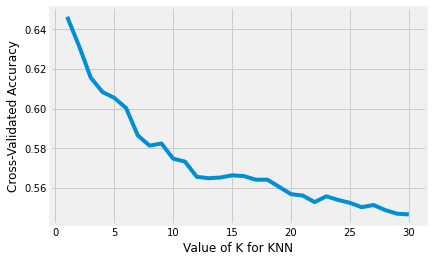

In [361]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');